<font size= 10> **Prospect Theory SWB Model Parameter Recovery**


Goal of SWB prospect theory models is to capture individual subject's risk aversion, loss aversion, and choice probability to generate utility-based expected values of each trial for each subject. If recoverable, these models will be used to estimate subjective wellbeing ratings. Here, models are recovered independent from ratings. 

# SWB Prospect Theory Models:
1. Base PT Model
    - free params: loss aversion, risk aversion, temp
2. Dual Risk Aversion PT Model:
    - free params: loss aversion, gain risk aversion, loss risk aversion, temp


Goal of SWB prospect theory models is to capture individual subject's risk aversion, loss aversion, and choice probability to generate utility-based expected values of each trial for each subject. If recoverable, these models will be used to estimate subjective wellbeing ratings. Here, models are validated through behavioral simulations. Simulated agents behavior should reflect sensible decision making and be logically consistent with model parameter values. 

# PT Model Free Parameters 
**Risk Aversion**
- non negative utility exponent 
- risk neutral = 1
- risk seeking > 1
- risk averse < 1
- bounds 0-3 (needs verification, rutledge constrained 0.3-1.3, charpentier 0-3)

**Loss Aversion**
- non negative utility coefficient  
- loss neutral = 1
- loss averse > 1
- loss tolerant < 1
- bounds 0-6 (needs verification, rutledge constrained 0.5-5, charpentier 0-5)

**Inverse Temperature**
- non negative decision stochasticity exponent
- completely random = 0
- completely deterministic for highest value = + inf
- bounds 0-10 (needs verification, some constrain up to 20)



# Recovery Evaluation (for each model): 

1. Input known parameters into the model and use the model to simulate data
2. Run MLE optimization to estimate parameters
3. Test whether the parameters estimated from the simulation datasets are tightly correlated with the known parameters
4. Make figures 

In [1]:
import numpy as np
import random
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize # minimize function is used for parameter recovery 
import seaborn as sns 
import tqdm
from scipy.stats import spearmanr,pearsonr
import statsmodels.api as sm
import os
from scipy.stats import norm
import pickle
import datetime
from joblib import Parallel, delayed
import itertools
from scipy.stats import norm



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%reload_ext autoreload
%autoreload 2

In [9]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
import SWB_modeling_utils

sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/pyEM')
import pyEM.math, pyEM.fitting, pyEM.plotting

In [4]:
# get date info for data/fig saving
date = datetime.date.today().strftime('%m%d%Y')
print(date)
# set directories
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
# create fig saving directory
fig_dir = f'{base_dir}swb_computational_modeling/figs/pt_recovery_emmap/'
os.makedirs(fig_dir,exist_ok = True) 


01142024


In [5]:
%matplotlib inline

#### set theme for all plots
sns.set_theme(style='ticks',font='Arial') 
sns.set_context("talk")

In [10]:
def simulate_base_pt(params,trials):
    #inputs: 
    #params - risk, loss, temp
    #trials - number of trials for simulation (for EMU SWB always 150)
    risk_aversion, loss_aversion, inverse_temp = params

    # init list of choice prob predictions
    tr = []
    trial_list = []
    choice_prob = []
    choice_pred = []
    util_g = []
    util_s = []
    choice_util = []
    p_g = []
    p_s = []
    safe = []
    high = []
    low = []

    #load task code master df 
    swb_trial_master = pd.read_csv('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/swb_trial_master.csv')

    task = swb_trial_master.sample(frac = 1) #randomize task order 

    #loop through trials
    for trial in range(len(task)):

        trial_type = task.TrialType.iloc[trial]
        safe_bet = task.SafeBet.iloc[trial]
        high_bet = task.HighBet.iloc[trial]
        low_bet = task.LowBet.iloc[trial]
        trial_list.append(trial_type)

        safe.append(safe_bet)
        high.append(high_bet)
        low.append(low_bet)


        # transform to high bet value to utility (gamble)
        if high_bet > 0: #mix or gain trials
            weighted_high_bet = 0.5 * ((high_bet)**risk_aversion)
        else: #loss trials
            weighted_high_bet = 0 # -0.5 * loss_aversion * (-high_bet)**risk_aversion - this is never the case so changed to zero 
        
        # transform to low bet value to utility (gamble)
        if low_bet >= 0: #gain trials
            weighted_low_bet = 0 #0.5 * (low_bet)**risk_aversion - this is never the case so changed to zero 
        else: #loss and mix trials
            weighted_low_bet = -0.5 * loss_aversion * ((-low_bet)**risk_aversion)
        
        util_gamble = weighted_high_bet + weighted_low_bet
    

        # transform safe bet value to utility (safe)
        if safe_bet >= 0: #gain or mix trials
            util_safe = (safe_bet)**risk_aversion
        else: #loss trials
            util_safe = -loss_aversion * ((-safe_bet)**risk_aversion)
        
        # utility options for calculating EV - utils separate, ug - us to combine or Uchosen - Unchosen (will differ by participant) 
        #inverse temp < 1 more exporatory, > 1 more exploitative
        # convert EV to choice probabilities via softmax
        p_gamble = np.exp(inverse_temp*util_gamble) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        p_safe = np.exp(inverse_temp*util_safe) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        

        util_g.append(util_gamble)
        util_s.append(util_safe)
        p_g.append(p_gamble)
        p_s.append(p_safe)

        choice = random.choices(['gamble','safe'],weights=[p_gamble,p_safe])[0]
        choice_pred.append(choice)

        if choice == 'gamble':
            choice_prob.append(p_gamble)
            choice_util.append(util_gamble)
        else:
            choice_prob.append(p_safe)
            choice_util.append(util_safe)

        tr.append(trial)



    data = {'tr':tr,'TrialType':trial_list,'GambleChoice':choice_pred,'ChoiceProb':choice_prob, 'ChoiceUtil':choice_util,
                       'util_gamble':util_g,'util_safe':util_s,'p_gamble':p_g,'p_safe':p_s,'SafeBet':safe,'HighBet':high,'LowBet':low}
    DF = pd.DataFrame(data)
    
    return DF

In [11]:
def norm2riskaversion(aversion_param):
    return 2 / (1 + np.exp(-aversion_param))

def norm2lossaversion(aversion_param):
    return 6 / (1 + np.exp(-aversion_param))

def norm2invtmp(invtemp):
    return 10 / (1 + np.exp(-invtemp))

In [40]:
def negll_base_pt_pyEM(params, subj_df, prior=None, output='npl'):

    risk_aversion, loss_aversion, inverse_temp = params
    
    risk_aversion = norm2riskaversion(risk_aversion) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
    risk_aversion_bounds = [0.00001, 2] #set upper and lower bounds
    if risk_aversion< min(risk_aversion_bounds) or risk_aversion> max(risk_aversion_bounds): #prevent estimation from parameter values outside of bounds 
        return 10000000
    
    loss_aversion = norm2lossaversion(loss_aversion) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
    loss_aversion_bounds = [0.00001, 6] #set upper and lower bounds
    if loss_aversion< min(loss_aversion_bounds) or loss_aversion> max(loss_aversion_bounds):  #prevent estimation from parameter values outside of bounds 
        return 10000000
    
    inverse_temp = norm2invtmp(inverse_temp) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
    this_beta_bounds = [0.00001, 10]  #set upper and lower bounds
    if inverse_temp < min(this_beta_bounds) or inverse_temp > max(this_beta_bounds):  #prevent estimation from parameter values outside of bounds 
        return 10000000

    #Initialize choice probability vector to calculate negative log likelihood
    choice_prob_list = []
    choice_list = []

    #Initialize empty data vectors to return all relevant data if output = 'all'
    tr          = []
    trial_list  = []
    util_g      = []
    util_s      = []
    choice_util = []
    p_g         = []
    p_s         = []
    safe        = []
    high        = []
    low         = []
    w_safe      = []
    w_high      = []
    w_low       = []

    for trial in range(len(subj_df)):

        trial_info = subj_df.iloc[trial]
        trial_type = trial_info['TrialType']
        choice = trial_info['GambleChoice']
        high_bet = trial_info['HighBet']
        low_bet = trial_info['LowBet']
        safe_bet = trial_info['SafeBet']


        #store trial info 
        choice_list.append(choice)
        tr.append(trial)
        trial_list.append(trial_type)
        high.append(high_bet)
        low.append(low_bet)
        safe.append(safe_bet)

        ##### Utility calculations #####

        # transform to high bet value to utility (gamble)
        if high_bet > 0: #mix or gain trials
            weighted_high_bet = 0.5 * ((high_bet)**risk_aversion)
        else: #loss trials
            weighted_high_bet = 0 
        
        w_high.append(weighted_high_bet)

        # transform to low bet value to utility (gamble)
        if low_bet < 0: #loss and mix trials
            weighted_low_bet = -0.5 * loss_aversion * ((-low_bet)**risk_aversion)
            
        else: #gain trials
            weighted_low_bet = 0 
        
        w_low.append(weighted_low_bet)
        
        util_gamble = weighted_high_bet + weighted_low_bet
        util_g.append(util_gamble)
    

        # transform safe bet value to utility (safe)
        if safe_bet >= 0: #gain or mix trials
            util_safe = (safe_bet)**risk_aversion
        else: #loss trials
            util_safe = -loss_aversion * ((-safe_bet)**risk_aversion)

        w_safe.append(util_safe)
        util_s.append(util_safe)


        ##### Choice probability calculation #####

        # convert EV to choice probabilities via softmax
        p_gamble = np.exp(inverse_temp*util_gamble) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        p_safe = np.exp(inverse_temp*util_safe) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        # p_safe = 1-p_gamble

        # append probability of chosen options
        if choice == 'gamble':
            choice_prob_list.append(p_gamble)
            choice_util.append(util_gamble)

        elif choice == 'safe':
            choice_prob_list.append(p_safe)
            choice_util.append(p_safe)

    # calculate negative log likelihood of choice probabilities 
            
    negll = -np.sum(np.log(choice_prob_list))
    
    if np.isnan(negll):
        negll = np.inf
    
    if output == 'npl':
        if prior is not None:  # EM-fit: P(Choices | h) * P(h | O) should be maximised, therefore same as minimizing it with negative sign
            fval = -(-negll + prior['logpdf'](params))

            if any(prior['sigma'] == 0):
                this_mu = prior['mu']
                this_sigma = prior['sigma']
                this_logprior = prior['logpdf'](params)
                print(f'mu: {this_mu}')
                print(f'sigma: {this_sigma}')
                print(f'logpdf: {this_logprior}')
                print(f'fval: {fval}')
            
            if np.isinf(fval): 
                fval = 10000000
            return fval
        else: # NLL fit 
            return negll
        
    elif output == 'all': #WHATEVER YOU WANT TO OUTPUT IF NOT OPTIMIZING
        subj_dict = {'params'      : [risk_aversion, loss_aversion, inverse_temp],
                     'tr'          : tr,
                     'TrialType'   : trial_list,
                     'GambleChoice':choice_list,
                     'ChoiceProb'  : choice_prob_list,
                     'ChoiceUtil'  : choice_util,
                     'util_gamble' : util_g,
                     'util_safe'   : util_s, 
                     'p_gamble'    : p_g,
                     'p_safe'      : p_s,
                     'HighBet'     : high,
                     'LowBet'      : low,
                     'SafeBet'     : safe,
                     'WeightedHigh': w_high,
                     'WeightedLow' : w_low,
                     'WeightedSafe': w_safe,
                     'negll'       : negll,
                     'bic'         : len(params) * np.log(150) + 2*negll}
        
        return subj_dict

# Visualize Fitted Parameters from SWB Subj

In [13]:
##### load mle fit data from swb subj 

### load pickle dicts
data_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/'
swb_emmap_fits = pickle.load(open(f'{data_dir}swb_pt_EMMAP_dict_01122024.pkl', 'rb' ) )

subj_ids = list(swb_emmap_fits.keys())



In [19]:
swb_emmap_fits['params'][0]

array([1.16153177, 3.66468798, 3.54287276])

In [20]:
risk_dist    = []
loss_dist    = []
invtemp_dist = []

for params in swb_emmap_fits['params']:
    risk_dist.append(params[0])
    loss_dist.append(params[1])
    invtemp_dist.append(params[2])


(0.931, 1.437, 0.563, 0.807)


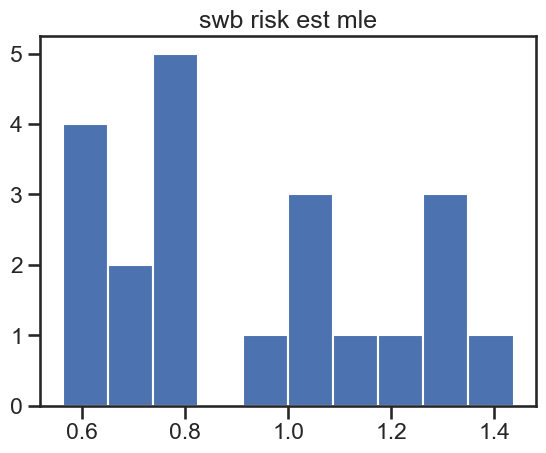

In [21]:
plt.hist(risk_dist)
plt.title('swb risk est mle')
risk_ranges = (np.round(np.mean(risk_dist),3),np.round(np.max(risk_dist),3),np.round(np.min(risk_dist),3),np.round(np.median(risk_dist),3))
print(risk_ranges)

(1.327, 3.844, 0.055, 1.034)


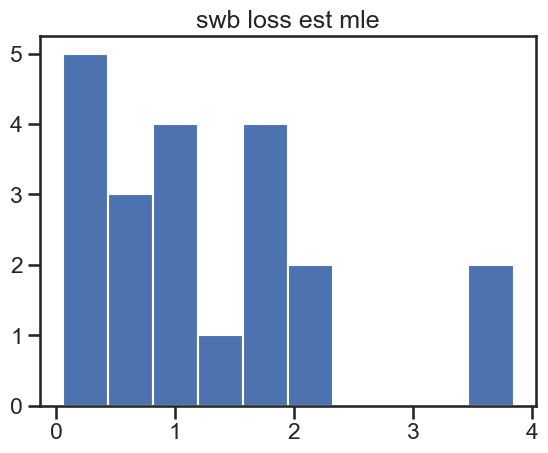

In [22]:
plt.hist(loss_dist)
plt.title('swb loss est mle')
loss_ranges = (np.round(np.mean(loss_dist),3),np.round(np.max(loss_dist),3),np.round(np.min(loss_dist),3),np.round(np.median(loss_dist),3))
print(loss_ranges)

(3.486, 5.447, 1.629, 3.197)


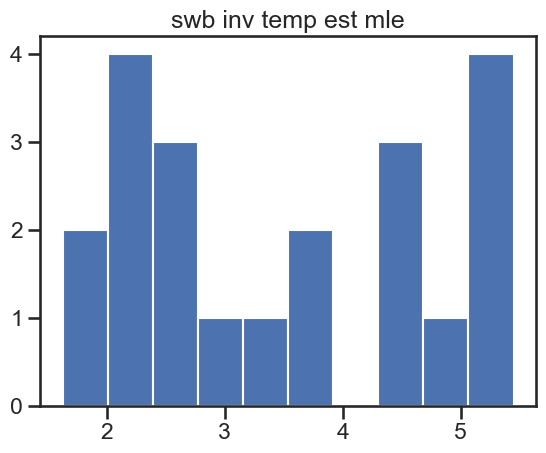

In [23]:
plt.hist(invtemp_dist)
plt.title('swb inv temp est mle')
invtemp_ranges = (np.round(np.mean(invtemp_dist),3),np.round(np.max(invtemp_dist),3),np.round(np.min(invtemp_dist),3),np.round(np.median(invtemp_dist),3))
print(invtemp_ranges)

# Simulation with known parameters

In [28]:
# Create grid of known param values for simulation from dist of swb pt fits 
# sim values for each parameter are the mean, maximum, minimum, & median of real subj fits 

risk_sims     =  norm.rvs(np.round(np.mean(risk_dist),3), np.round(np.std(risk_dist),3), size=100)
risk_sims[risk_sims>2] = 1.95
risk_sims[risk_sims<=0] = 0.01

loss_sims     =  norm.rvs(np.round(np.mean(loss_dist),3), np.round(np.std(loss_dist),3), size=100)
loss_sims[loss_sims>6] = 5.95
loss_sims[loss_sims<=0] = 0.01

invtemp_sims  =  norm.rvs(np.round(np.mean(invtemp_dist),3), np.round(np.std(invtemp_dist),3), size=100)
invtemp_sims[invtemp_sims>10] = 9.95
invtemp_sims[invtemp_sims<=0] = 0.01
# print(risk_sims,loss_sims,invtemp_sims)


In [29]:
# create agents 

number_of_trials = 150 #number of trials per agent

map_recovery_sim_dict = {}

for param_values in zip(risk_sims,loss_sims,invtemp_sims):
    agent_df = simulate_base_pt(param_values,number_of_trials)
    map_recovery_sim_dict[param_values] = agent_df

map_recovery_sim_dict

{(0.6805453108160158,
  0.01,
  2.200810742980015):       tr TrialType GambleChoice  ChoiceProb  ChoiceUtil  util_gamble  \
 0      0       mix       gamble    0.621821    0.225956     0.225956   
 1      1       mix       gamble    0.822811    0.697701     0.697701   
 2      2       mix       gamble    0.681956    0.346588     0.346588   
 3      3      gain         safe    0.584471    0.623929     0.468917   
 4      4      loss         safe    0.498883   -0.007064    -0.005034   
 ..   ...       ...          ...         ...         ...          ...   
 145  145      gain         safe    0.452730    0.440714     0.526886   
 146  146       mix       gamble    0.615494    0.213768     0.213768   
 147  147      gain       gamble    0.502604    0.628661     0.628661   
 148  148      loss         safe    0.499292   -0.004407    -0.003120   
 149  149      gain         safe    0.476835    0.440714     0.482847   
 
      util_safe  p_gamble    p_safe  SafeBet  HighBet  LowBet  
 0     

In [32]:
save_path = f'{base_dir}swb_computational_modeling/swb_behav_models/data/pt_recovery_emmap/'
os.makedirs(save_path,exist_ok = True) 

# create a binary pickle file 
f = open(f'{save_path}swb_emmap_recovery_sim_inputs_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(map_recovery_sim_dict,f)
# # close file
f.close()

# Fit Pt Model w MLE

In [34]:
known_sim_params = list(map_recovery_sim_dict.keys())

In [37]:
# store sim behav in list of dfs to input in pyEM
sim_behav = []
for params in map_recovery_sim_dict.keys():
    sim_behav.append(map_recovery_sim_dict[params])


In [41]:
#run pyEM on all subjects 

param_names = ['risk_aversion','loss_aversion','inverse_temp']
m, inv_h, posterior, NPL, NLPrior, NLL = pyEM.fitting.EMfit(sim_behav, negll_base_pt_pyEM, param_names)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [42]:
#transform gaussian params into native model space (using sigmoid function)

param_names = ['risk_aversion','loss_aversion','inverse_temp']
nparams = len(param_names)

#extract estimated parameter values in gaussian space  
est_params = m.T.copy() #rows = subj, cols = params


for sim_idx in range(len(map_recovery_sim_dict.keys())): #iterate through each subject
    for param_idx, param_name in enumerate(param_names): #iterate through each free parameter 
        if 'risk_aversion' == param_name:
            est_params[sim_idx, param_idx] = norm2riskaversion(m[param_idx, sim_idx]) #replace gaussian value with transformed value in param matrix 
        elif 'loss_aversion' == param_name:
            est_params[sim_idx, param_idx] = norm2lossaversion(m[param_idx, sim_idx]) #replace gaussian value with transformed value in param matrix 
        elif 'inverse_temp' == param_name: 
            est_params[sim_idx, param_idx] = norm2invtmp(m[param_idx, sim_idx]) #replace gaussian value with transformed value in param matrix 

est_params #each row is the 3 param estimates for each subj 
# can also make this a dataframe next time 

array([[0.57099227, 0.40847674, 3.73549362],
       [0.76345764, 0.88350446, 4.22754815],
       [1.00164638, 2.09158767, 4.56189767],
       [0.38446046, 1.99244736, 5.32435708],
       [1.17892725, 0.99042167, 4.69042209],
       [1.01224351, 1.95026495, 3.89194863],
       [1.1483232 , 1.4613573 , 4.65830172],
       [1.05857447, 1.76122204, 2.8859487 ],
       [0.87126243, 2.41642941, 4.10701621],
       [1.369634  , 3.22164465, 5.80565182],
       [0.70118512, 0.73163621, 3.64538951],
       [0.82817097, 1.24398646, 4.05374005],
       [0.95302118, 1.82838127, 5.27350984],
       [0.677552  , 0.99834363, 3.68386288],
       [0.9147591 , 2.03179333, 3.86024047],
       [1.07599719, 1.23914075, 4.60680997],
       [0.81785385, 0.39796696, 5.44534175],
       [1.02873213, 1.19137081, 4.46374667],
       [0.78644518, 1.10372463, 5.15065822],
       [1.24445335, 2.42374697, 4.9939283 ],
       [0.70822808, 0.49107671, 4.29999271],
       [1.26925728, 1.28087052, 5.97666404],
       [0.

In [44]:
# compute mean, std of posterior distributions & covariance matrix from inv hessians (just non-diag elements of inv hessian for all param combos)
posterior_mu, posterior_std, _, covariance_mat = pyEM.math.compGauss_ms(m,inv_h,2) #posterior mu/std is same here as in EMfit output 

covariance_mat #covariance between free parameters 

array([[0.30839101, 0.08943268, 0.00316772],
       [0.08943268, 0.84491045, 0.01349138],
       [0.00316772, 0.01349138, 0.20831928]])

In [45]:
#combine results into dictionary to save 
recovery_pyEM_map_dict = {}

recovery_pyEM_map_dict['gauss_params'] = m
recovery_pyEM_map_dict['params'] = est_params
recovery_pyEM_map_dict['param_names'] = param_names
recovery_pyEM_map_dict['inverse_hess'] = inv_h
recovery_pyEM_map_dict['gauss_posterior_mu'] = posterior['mu']
recovery_pyEM_map_dict['gauss_posterior_std'] = posterior['sigma']
recovery_pyEM_map_dict['gauss_covariance_mat'] = covariance_mat
recovery_pyEM_map_dict['npl'] = NPL #negative joint posterior likelihood (current convergence criteria)
recovery_pyEM_map_dict['NLPrior'] = NLPrior #negative log prior estimate
recovery_pyEM_map_dict['nll'] =  NPL - NLPrior #negative log likelihood (neg joint posterior ll - neg log prior)
recovery_pyEM_map_dict['bic'] =  np.log(150)*nparams + 2*recovery_pyEM_map_dict['nll'] 
recovery_pyEM_map_dict['aic'] =  2*nparams + 2*recovery_pyEM_map_dict['nll']
recovery_pyEM_map_dict['lme'] = [] #not calculated yet - convergence type = npl instead 

# swb_pt_MAP_dict

In [50]:
# Use parameter estimations to fit pt model to subjects and save data dicts --- remember to use gaussian form of vars!  est_params[subj_idx,:]
recovery_EMMAP_sim_fits = {}

for param_idx in range(len(map_recovery_sim_dict.keys())):
    params = m[:,param_idx] #make sure these are the gaussian parameter values 
    df = sim_behav[param_idx]
    sim_fit_dict = negll_base_pt_pyEM(params, df, prior=None, output='all')
    recovery_EMMAP_sim_fits[param_idx] = sim_fit_dict

recovery_EMMAP_sim_fits

{0: {'params': [0.5709922732700571, 0.40847674401434453, 3.735493621139115],
  'tr': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   

In [51]:
#### save estimation dict 
save_path = f'{base_dir}swb_computational_modeling/swb_behav_models/data/pt_recovery_emmap/'
os.makedirs(save_path,exist_ok = True) 

date = datetime.date.today().strftime('%m%d%Y')

# create a binary pickle file 
f = open(f'{save_path}recovery_pyEM_map_dict_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(recovery_pyEM_map_dict,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}recovery_EMMAP_sim_fits_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(recovery_EMMAP_sim_fits,f)
# # close file
f.close()

# Compare Known Simulation Parameters and Model Fit Output

In [52]:
### load pickle dicts
save_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/data/pt_recovery_emmap/'
recovery_map_dict = pickle.load(open(f'{save_dir}recovery_pyEM_map_dict_01142024.pkl', 'rb' ) )


In [56]:
# extract estimated params for all subj
risk_est    = []
loss_est    = []
invtemp_est = []


for params in recovery_map_dict['params']:
    risk_est.append(params[0])
    loss_est.append(params[1])
    invtemp_est.append(params[2])


# risk_est = est_params[:,0]
# loss_est = est_params[:,1]
# invtemp_est = est_params[:,2]

In [59]:
# extract known simulation parameters as lists 
risk_known    = []
loss_known    = []
invtemp_known = []


for params in map_recovery_sim_dict.keys():
    risk_known.append(params[0])
    loss_known.append(params[1])
    invtemp_known.append(params[2])

# print(risk_known,loss_known,invtemp_known)


In [60]:
list(zip(risk_known,risk_est))

[(0.6805453108160158, 0.5709922732700571),
 (0.9535620679214342, 0.7634576371177614),
 (1.0624715709677217, 1.0016463769794248),
 (0.3642495526624653, 0.3844604611303881),
 (1.3214220960010268, 1.1789272469023961),
 (0.9988349607284269, 1.0122435050811112),
 (1.175612274175193, 1.1483232004509931),
 (1.1518518572593723, 1.0585744692810493),
 (0.9015313355215058, 0.871262431235277),
 (1.2700681888144605, 1.3696340021722027),
 (0.8988532703877311, 0.7011851239411896),
 (0.8933553094091398, 0.8281709719344448),
 (1.0850689225981323, 0.9530211791878388),
 (1.3892498169500083, 0.6775519958408969),
 (1.124158599463332, 0.9147591047939647),
 (1.3976951815443333, 1.075997188171734),
 (1.058241232117049, 0.8178538547319959),
 (1.1441734872746416, 1.0287321285605915),
 (0.8392473487374654, 0.7864451845500144),
 (1.1762117766811226, 1.2444533450202497),
 (0.9320497343551555, 0.7082280758944938),
 (1.248984852723407, 1.2692572759152376),
 (0.76000739861575, 0.8303302014918487),
 (0.433955813763421

In [61]:
risk_corr, risk_p = spearmanr(risk_known,risk_est)
print('Spearman correlation: %.3f' % risk_corr)
print(risk_p)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation: 0.855
9.62270075197862e-30


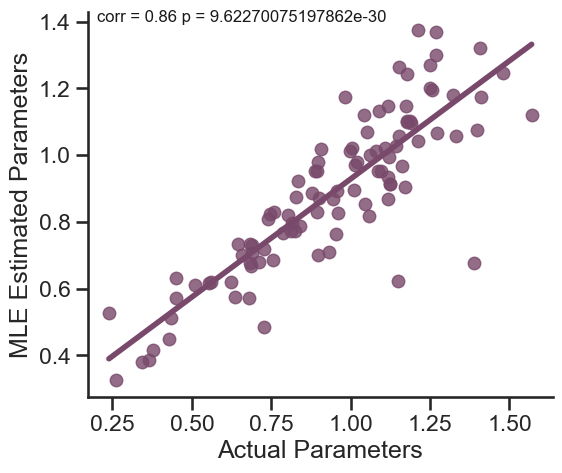

In [66]:
#plot estimated risk aversion parameters with known risk aversion parameters

fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=risk_known, y=risk_est, color = '#78496b',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.2, 1.4,f'corr = {np.round(risk_corr,2)} p = {risk_p}',fontsize=12,color = 'k')
plt.xlabel('Actual Parameters')
plt.ylabel('MLE Estimated Parameters')
sns.despine()


plt.savefig(f'{fig_dir}risk_aversion_emmap_recovery_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [67]:
loss_corr, loss_p = spearmanr(loss_known,loss_est)
print('Spearman correlation: %.3f' % loss_corr)
print(loss_p)

Spearman correlation: 0.962Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

6.187387006713253e-57


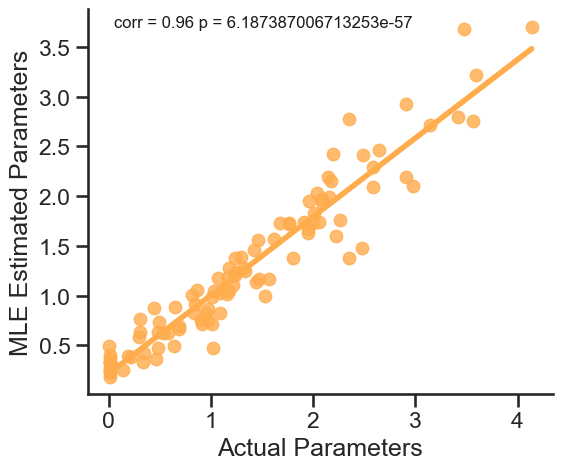

In [70]:
#plot estimated loss aversion parameters with known loss aversion parameters

fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=loss_known, y=loss_est, color = '#ffac4d',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.05, 3.7,f'corr = {np.round(loss_corr,2)} p = {loss_p}',fontsize=12,color = 'k')
plt.xlabel('Actual Parameters')
plt.ylabel('MLE Estimated Parameters')
sns.despine()


plt.savefig(f'{fig_dir}loss_aversion_emmap_recovery_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


#### keep inverse temp above 0.5 

In [71]:
invtemp_corr, invtemp_p = spearmanr(invtemp_known,invtemp_est)
print('Spearman correlation: %.3f' % invtemp_corr)
print(invtemp_p)

Spearman correlation: 0.729Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

8.29757979223647e-18


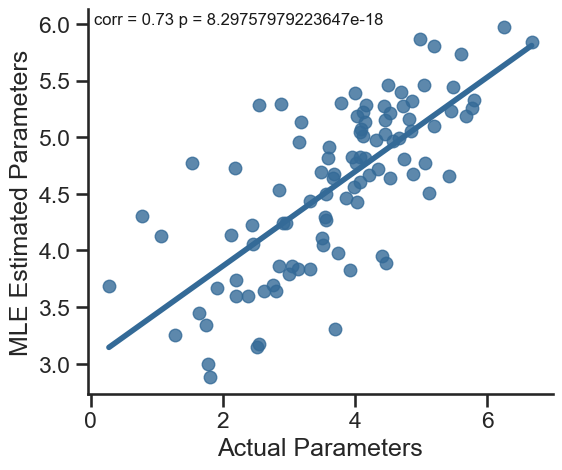

In [73]:
#plot estimated inverse temp parameters with known inverse temp parameters

# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=invtemp_known, y=invtemp_est, color = '#346a97',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.05, 6,f'corr = {np.round(invtemp_corr,2)} p = {invtemp_p}',fontsize=12,color = 'k')
plt.xlabel('Actual Parameters')
plt.ylabel('MLE Estimated Parameters')
sns.despine()


plt.savefig(f'{fig_dir}inverse_temperature_emmap_recovery_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 
